## Source of Articles by Political Affiliation

We can analyze the sources of news across the liberal and conservative communities we scraped.  We first import all of the necessary packages and load in scraped articles.

In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from PIL import Image

from mutual_information import class_table, mutual_info

Using TensorFlow backend.


In [2]:
articles_df = pd.read_csv('article_scraping/Articles_50000.csv')

We now separate out the lists of websites linked by liberals and by conservatives.  We remove any generic non-political websites, such as facebook and youtube.

In [3]:
cons_sites = articles_df[articles_df['Affiliation (0=conservative)']==0]['Website'].fillna(' ').tolist()
lib_sites = articles_df[articles_df['Affiliation (0=conservative)']==1]['Website'].fillna(' ').tolist()

#get rid of stop sites and sites not in the form _____.com
stop_sites = ['twitter','youtube','facebook','reddit','imgur']

cons_sites = [s.split('.')[0] for s in cons_sites if len(s.split('.'))==2 and s.split('.')[1]=='com' and \
             s.split('.')[0] not in stop_sites]
lib_sites = [s.split('.')[0] for s in lib_sites if len(s.split('.'))==2 and s.split('.')[1]=='com' and \
             s.split('.')[0] not in stop_sites]

Let's tokenize these lists and compute the mutual information for each source to determine which sources are distinctive to which political affiliation.  We only take sites which were shared at least 50 times, to weed out random websites with little content or readership.

In [4]:
lib_token = Tokenizer()
cons_token = Tokenizer()
all_token = Tokenizer()

lib_token.fit_on_texts(lib_sites)
cons_token.fit_on_texts(cons_sites)
all_token.fit_on_texts(cons_sites+lib_sites)

In [5]:
sites=np.array([s for s,val in all_token.word_index.items() if all_token.word_counts[s]>50])

MI_lib, MI_cons = np.zeros([len(sites),]), np.zeros([len(sites),])

for n,site in enumerate(tqdm.tqdm(sites)):
    MI_lib[n] = mutual_info(class_table(site,lib_token,len(lib_sites),cons_token,len(cons_sites)))
    MI_cons[n] = mutual_info(class_table(site,cons_token,len(cons_sites),lib_token,len(lib_sites)))

100%|██████████| 100/100 [00:00<00:00, 18753.04it/s]


We can now examine the sites shared disproportionately by the liberal subreddit and by the conservative subreddit.

In [6]:
print(sites[np.argsort(MI_cons)[-20:]])
print(sites[np.argsort(MI_lib)[-20:]])

['dailysignal' 'nypost' 'cnsnews' 'foxnews' 'theblaze' 'freebeacon'
 'legalinsurrection' 'conservativereview' 'pjmedia' 'americanthinker'
 'dailycaller' 'therightscoop' 'redstate' 'thefederalist' 'hotair'
 'townhall' 'thegatewaypundit' 'nationalreview' 'dailywire' 'breitbart']
['dailykos' 'newsweek' 'rawstory' 'buzzfeed' 'slate' 'talkingpointsmemo'
 'motherjones' 'thedailybeast' 'reuters' 'politicususa' 'vox' 'msnbc'
 'salon' 'politico' 'theguardian' 'thehill' 'cnn' 'nytimes'
 'huffingtonpost' 'washingtonpost']


Since the mutual information of a site is only nonzero for either liberal or conservative affiliation, we can define a total mutual information by simple subtraction.  More positive values of this total mutual information implies a liberal affiliation and more negative implies a conservative affiliation.

We can use this to examine sites which are shared relatively evenly between the two affiliations.

In [7]:
MI_tot = MI_lib - MI_cons
print(sites[np.argsort(np.abs(MI_tot))[:15]])

['fivethirtyeight' 'wsj' 'forbes' 'nationaljournal' 'msn' 'rt' 'medium'
 'observer' 'theweek' 'mcclatchydc' 'theintercept' 'marketwatch'
 'chicagotribune' 'inquisitr' 'mediaite']


Finally, we can plot this as a bar chart to examine the websites and their corresponding affiliation.

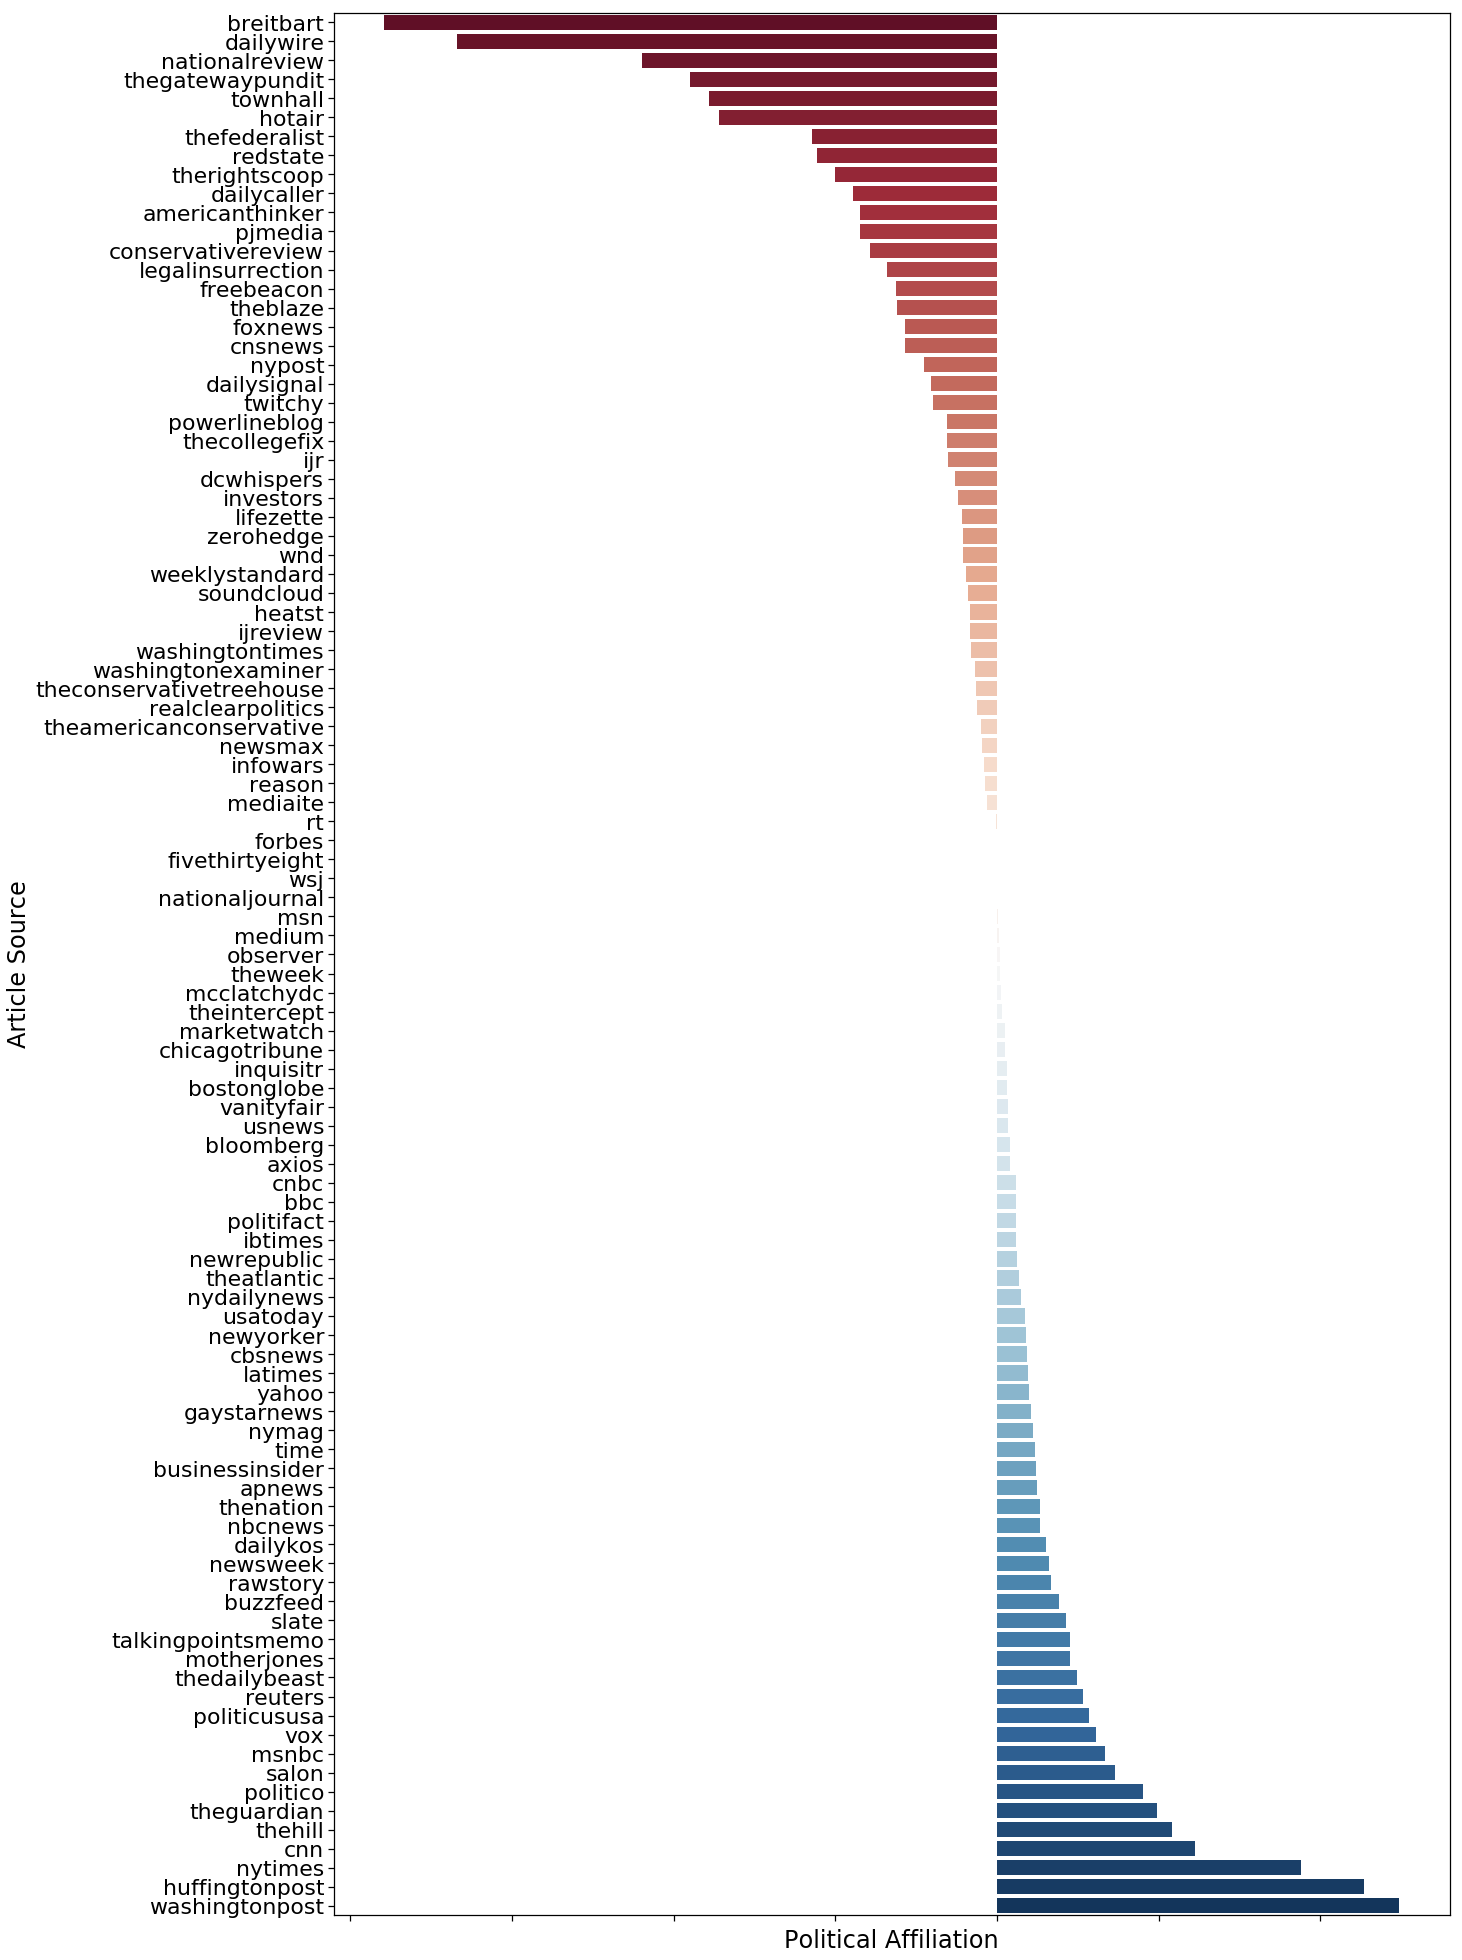

In [8]:
sort_inds = np.argsort(MI_tot)

plt.figure(figsize=(20,35))
sns.set_context("notebook", font_scale=2)
g = sns.barplot(y=sites[sort_inds],x=MI_tot[sort_inds],orient="h",palette="RdBu")
g.set(xticklabels=[])

plt.ylabel("Article Source")
plt.xlabel("Political Affiliation")
plt.savefig("Article_Source_Affiliation.png", bbox_inches='tight')

Looks good, but sites which are not linked very often are unlikely to show a large value of MI even if they are particularly partisan.  Another way to visualize this is through a bubble chart with each bubble representing a website and having area equal to the total number of times an article from that website was shared.  These bubbles are visualized with the proportion of red/blue representing the proportion of times each political community shared an article from that site.

In [10]:
from scipy.optimize import root
#create a function to draw a bubble for a given website
def draw_bubble(x0,y0,site,frac_lib,bubble_radius,text_scale):
    
    r = bubble_radius
    
    if frac_lib<=0.5:
        frac = frac_lib
        circ_color = '#F08080'
        segment_color = '#1E90FF'
        circ_sign = 1
    else:
        frac = 1-frac_lib
        circ_color = '#1E90FF' 
        segment_color = '#F08080'
        circ_sign = -1

    f_theta = lambda x: x-np.sin(x)-2*np.pi*frac
    mag_x = r*np.sin(root(f_theta, x0=np.pi/4).x[0]/2)
    
    x = np.arange(-mag_x,mag_x,.0001) + y0
    y = circ_sign*np.sqrt(r**2 - (x-y0)**2) + x0
    
    ax = plt.gca()
    ax.add_artist(plt.Circle((x0,y0),r,color=circ_color))
    ax.fill_between(y,x,y0,color=segment_color,zorder=2)
    
    ax.text(x0,y0-.1*r,site,fontsize=text_scale*r,horizontalalignment='center',zorder=3)

In [11]:
# Plot all of the bubbles so they are not overlapping.  The following was modified from:
# https://stackoverflow.com/questions/46131572/making-a-non-overlapping-bubble-chart-in-matplotlib-circle-packing

class C():
    def __init__(self,r):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        
        rand_inds = np.arange(self.N)
        np.random.shuffle(rand_inds)
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N][rand_inds]
        self.x[:,1] = gy.flatten()[:self.N][rand_inds]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 100*self.N:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    print(self.iter/(100*self.N),end='\r')
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self,text_scale=1):
        for i in range(self.N):
            draw_bubble(self.x[i,0],self.x[i,1],sites[i],lib_frac_shares[i],self.x[i,2]-1,text_scale)


/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


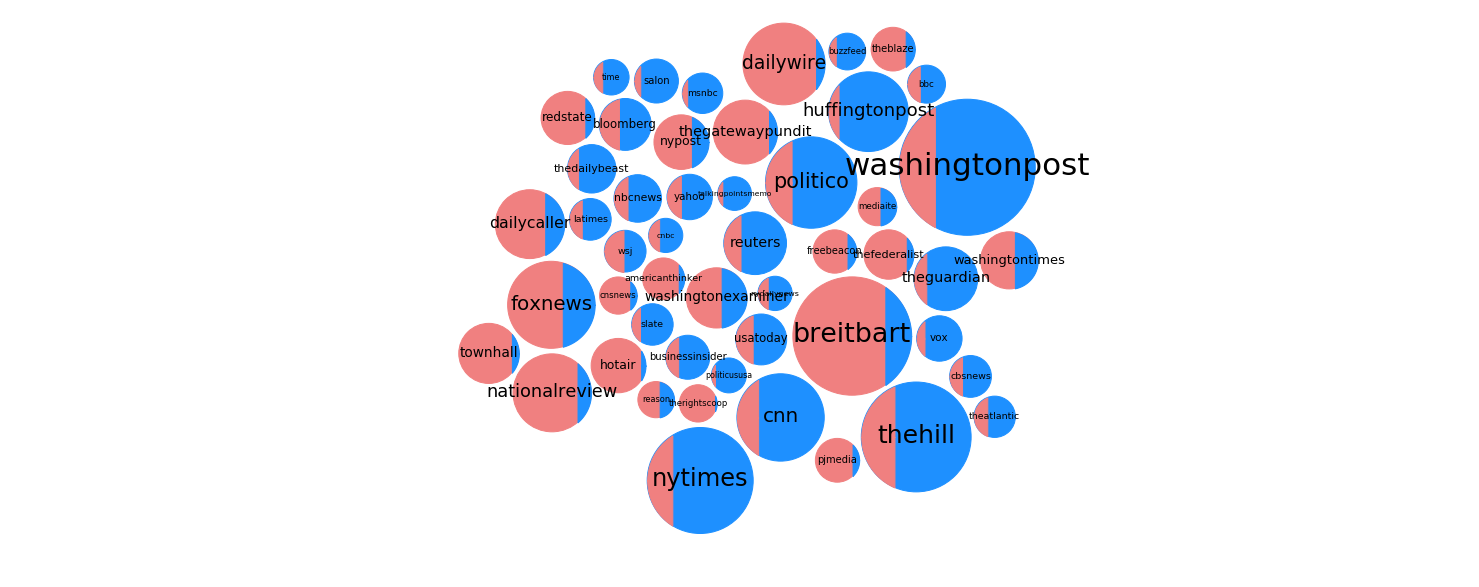

In [12]:
#create plot
n_shares = np.array([all_token.word_counts[s] for s in sites])
lib_frac_shares = np.array([lib_token.word_counts[s]/all_token.word_counts[s] for s in sites])

r = np.sqrt(n_shares[:50]/np.pi)

c = C(r)
c.minimize()

plt.figure(figsize=(25,10))
plt.axis("off")

c.plot(1.25)
plt.axes().set_aspect('equal', 'datalim')